# Springboard Time Series - 'Cowboy Cigarettes' Case Study - Tier 3

## Brief

You're working in the US federal government as a data scientist in the Health and Environment department. You've been tasked with determining whether sales for the oldest and most powerful producers of cigarettes in the country are increasing or declining. 

**Cowboy Cigarettes (TM, *est.* 1890)** is the US's longest-running cigarette manufacturer. Like many cigarette companies, however, they haven't always been that public about their sales and marketing data. The available post-war historical data runs for only 11 years after they resumed production in 1949; stopping in 1960 before resuming again in 1970. Your job is to use the 1949-1960 data to predict whether the manufacturer's cigarette sales actually increased, decreased, or stayed the same. You need to make a probable reconstruction of the sales record of the manufacturer - predicting the future, from the perspective of the past - to contribute to a full report on US public health in relation to major cigarette companies. 

The results of your analysis will be used as part of a major report relating public health and local economics, and will be combined with other studies executed by your colleagues to provide important government advice.  

-------------------------------
As ever, this notebook is **tiered**, meaning you can elect that tier that is right for your confidence and skill level. There are 3 tiers, with tier 1 being the easiest and tier 3 being the hardest.  

**1. Sourcing and loading** 
- Load relevant libraries 
- Load the data
- Explore the data

 
**2. Cleaning, transforming and visualizing**
- Dropping unwanted columns
- Nomenclature
- Type conversions
- Making a predictor variable `y` 
- Getting summary statistics for `y`
- Plotting `y`
  
  
**3. Modelling** 
- Decomposition
    - Trend
    - Seasonality
    - Noise
- Testing for stationarity with KPSS
- Making the data stationary
- The ARIMA Model
    - Make a function to find the MSE of a single ARIMA model
    - Make a function to evaluate the different ARIMA models with different p, d, and q values
- Visualize the results
- Application: Forecasting

**4. Evaluating and concluding** 
- What is our conclusion?
- Next steps
    

## 0. Preliminaries 

Time series data is just any data displaying how a single variable changes over time. It comes as a collection of metrics typically taken at regular intervals. Common examples of time series data include weekly sales data and daily stock prices. You can also easily acquire time series data from [Google Trends](https://trends.google.com/trends/?geo=US), which shows you how popular certain search terms are, measured in number of Google searches. 

## 1. Sourcing and Loading

### 1a. Load relevant libraries 

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import kpss
from math import sqrt
import warnings



### 1b. Load the data
Call the variable `cigData`. 

In [2]:
cigData = pd.read_csv(r"C:\Users\restr\Documents\Springboard\Cowboy Cigarettes\Cowboys&CigrettesCaseStudy\CowboyCigsData.csv")

### 1c. Explore the data
We now need to check whether the data conduces to a time series style analysis.

In [3]:
print(cigData.head())

   Unnamed: 0     Time  #CigSales
0           0  1949-01    1000112
1           1  1949-02    1000118
2           2  1949-03    1000132
3           3  1949-04    1000129
4           4  1949-05    1000121


Over a million cigarettes sold in the month of January 1949. This certainly is a popular cigarette brand. 

Check out the columns feature of the data. How many columns are there? 

In [4]:
print(cigData.columns)

Index(['Unnamed: 0', 'Time', '#CigSales'], dtype='object')


Let's check out the data types of our columns.

In [5]:
print(cigData.dtypes)

Unnamed: 0     int64
Time          object
#CigSales      int64
dtype: object


Check whether there are any null values. 

In [6]:
cigData.isnull().sum()

Unnamed: 0    0
Time          0
#CigSales     0
dtype: int64

## 2. Cleaning, transforming and visualizing

### 2a. Dropping unwanted columns
We need to cut that `Unnamed: 0` column. Delete it here.

In [7]:
cigData = cigData.drop(columns=['Unnamed: 0'])

### 2b. Nomenclature

We can see that the `Time` column actually has the granularity of months. Change the name of that column to `Month`.

In [8]:
cigData = cigData.rename(columns={'Time': 'Month'})

Call a head() to check this has worked. 

In [9]:
print(cigData.head())

     Month  #CigSales
0  1949-01    1000112
1  1949-02    1000118
2  1949-03    1000132
3  1949-04    1000129
4  1949-05    1000121


### 2c. Type conversions 

Now, do time series analysis on a Pandas dataframe is overkill, and is actually counter-productive. It's much more easy to carry out this type of analysis if we convert our data to a series first.

Notice that the `Month` field was an object. Let's type convert the `Month` column to a Python `datetime`, before making that the index.

In [10]:
cigData['Month'] = pd.to_datetime(cigData['Month'])

Perfect! 

### 2d. Making a predictor variable `y`

The data is now indexed by date, as time series data ought to be.

Since we want to predict the number of cigarette sales at Cowboy cigarettes, and `y` is typically used to signify a predictor variable, let's create a new variable called `y` and assign the indexed #Passenger column. 

In [11]:
y = cigData['#CigSales']

Check the type of our new variable. 

In [12]:
print(y.head())

0    1000112
1    1000118
2    1000132
3    1000129
4    1000121
Name: #CigSales, dtype: int64


### 2e. Getting summary statistics for `y`

Get the summary statistics of our data here. 

In [13]:
print(y.describe())

count    1.440000e+02
mean     1.000280e+06
std      1.199663e+02
min      1.000104e+06
25%      1.000180e+06
50%      1.000266e+06
75%      1.000360e+06
max      1.000622e+06
Name: #CigSales, dtype: float64


Try visualizing the data. A simple `matplotlib` plot should do the trick.  

### 2f. Plotting `y`

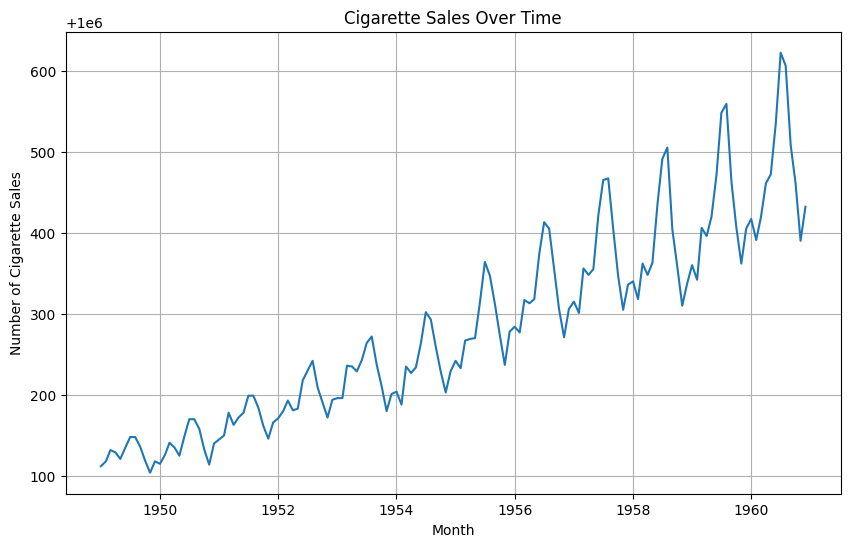

In [14]:
plt.figure(figsize=(10, 6))
plt.plot(cigData['Month'], y)
plt.title('Cigarette Sales Over Time')
plt.xlabel('Month')
plt.ylabel('Number of Cigarette Sales')
plt.grid(True)
plt.show()


## 3. Modelling 
### 3a. Decomposition
What do you notice from the plot? Take at least `2` minutes to examine the plot, and write down everything you observe.  

All done?

We can see that, generally, there is a trend upwards in cigarette sales from at Cowboy Cigarettes. But there are also some striking - and perhaps unexpected - seasonal fluctuations. These seasonal fluctations come in a repeated pattern. Work out when these seasonal fluctuations are happening, and take 2 minutes to hypothesize on their cause here.

What does it mean to *decompose* time series data? It means breaking that data into 3 components: 

1. **Trend**: The overall direction that the data is travelling in (like upwards or downwards)
2. **Seasonality**: Cyclical patterns in the data 
3. **Noise**: The random variation in the data

We can treat these components differently, depending on the question and what's appropriate in the context. They can either be added together in an *additive* model, or multiplied together in a *multiplicative* model. 

Make a coffee, take `5` minutes and read [this article](https://medium.com/@sigmundojr/seasonality-in-python-additive-or-multiplicative-model-d4b9cf1f48a7) and think about whether our data would conduce to an additive or multiplicative model here. Write your conclusion down just here: The chart shows how the magnitude of the seasonal pattern does vary in frequency and pattern over time. Thus we should use Multiplicative models. 

-------------------------------

All done? Well, just on the basis of the plot above, it seems our Cowboy Cigarettes data is actually multiplicative. 

That's because, as time progresses, the general trend seems to be increasing *at a rate that's also increasing*. We also see that the seasonal fluctuations (the peaks and troughs) get bigger and bigger as time progresses.

Now on the other hand, if the data were simply additive, we could expect the general trend to increase at a *steadily*, and a constant speed; and also for seasonal ups and downs not to increase or decrease in extent over time.

Happily, we can use the `decompose()` function to quantify the component parts described above in our data.

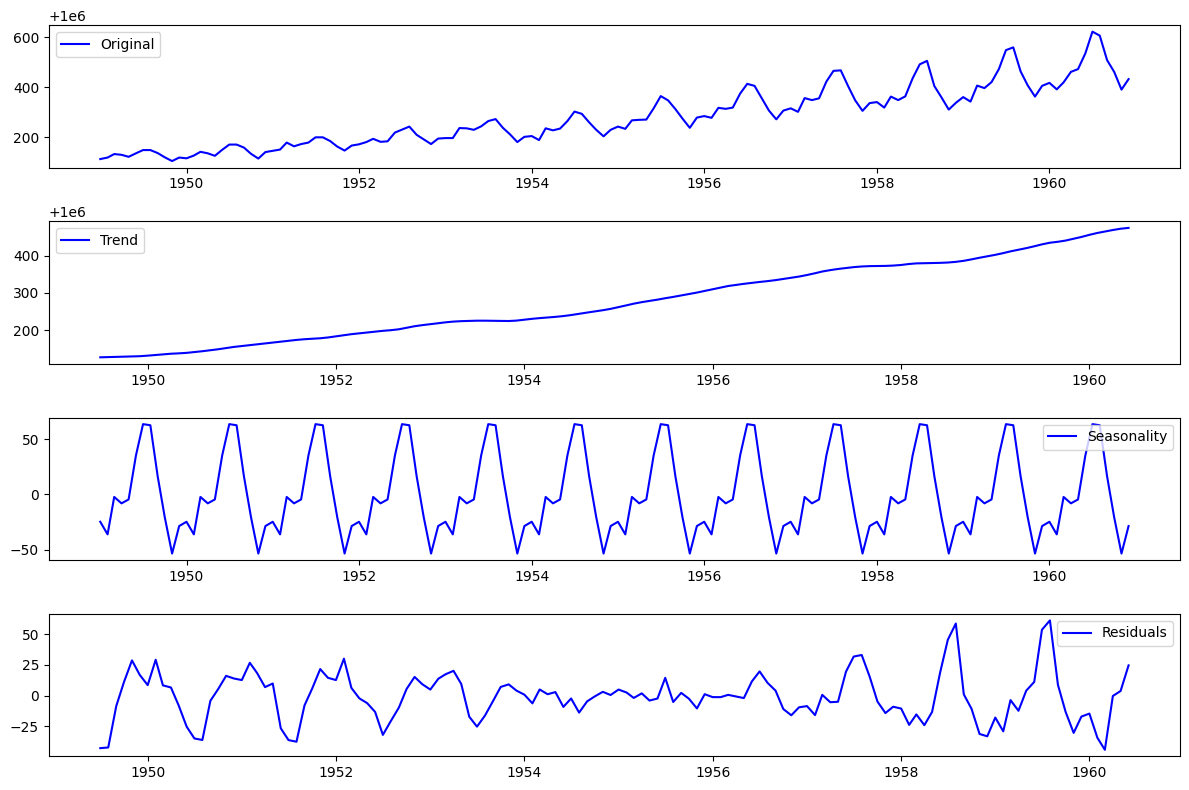

In [15]:
# Set 'Month' as the index for 'y'
y.index = cigData['Month']

# Resample the data to monthly frequency
y = y.resample('MS').mean()

# Perform seasonal decomposition
decomposition = seasonal_decompose(y)

# Plot the original data, the trend, the seasonality, and the residuals 
plt.figure(figsize=(12, 8))
plt.subplot(411)
plt.plot(y, label='Original', color='blue')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(decomposition.trend, label='Trend', color='blue')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(decomposition.seasonal,label='Seasonality', color='blue')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(decomposition.resid, label='Residuals', color='blue')
plt.legend(loc='best')
plt.tight_layout()


### 3b. Testing for stationarity with KPSS
As you know, when doing time series analysis we always have to check for stationarity. Imprecisely, a time series dataset is stationary just if its statistical features don't change over time. A little more precisely, a stationary time series dataset will have constant mean, variance, and covariance.

There are many ways to test for stationarity, but one of the most common is the KPSS test. The Null hypothesis of this test is that the time series data in question is stationary; hence, if the *p*-value is less than the significance level (typically 0.05, but we decide) then we reject the Null and infer that the data is not stationary.

In [16]:
# Define the KPSS test
def kpss_test(timeseries):
    print('Results of KPSS Test:')
    kpsstest = kpss(timeseries, regression='c')
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    return kpss_output

# Apply the KPSS test to the data
kpss_test(y)


Results of KPSS Test:


C:\Users\restr\AppData\Local\Temp\ipykernel_4896\3399100048.py:4: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpsstest = kpss(timeseries, regression='c')


Test Statistic           1.651312
p-value                  0.010000
Lags Used                8.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64

Since our p-value is less than 0.05, we should reject the Null hypothesis and deduce the non-stationarity of our data. 

But our data need to be stationary! So we need to do some transforming.

### 3c. Making the data stationary 
Let's recall what it looks like. 

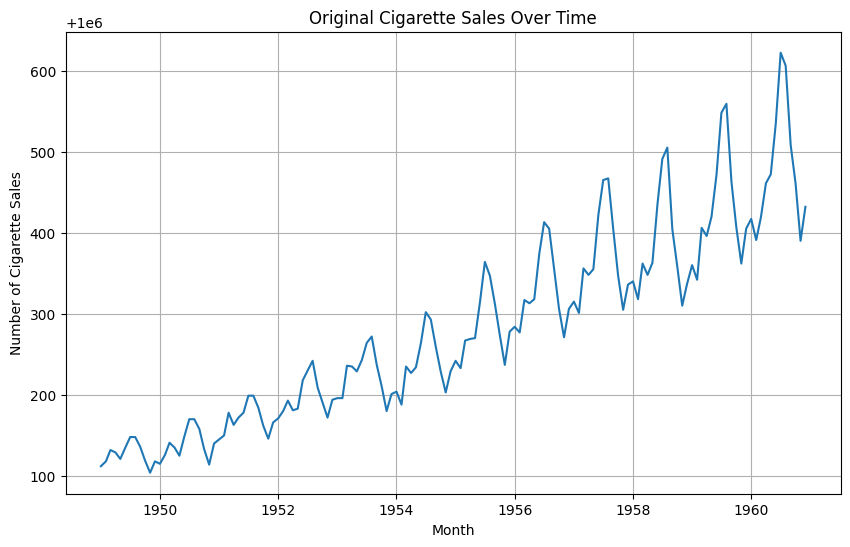

In [17]:
plt.figure(figsize=(10, 6))
plt.plot(y)
plt.title('Original Cigarette Sales Over Time')
plt.xlabel('Month')
plt.ylabel('Number of Cigarette Sales')
plt.grid(True)
plt.show()

In our plot, we can see that both the mean and the variance *increase as time progresses*. At the moment, our data has neither a constant mean, nor a constant variance (the covariance, however, seems constant). 

One ofte  used way of getting rid of changing variance is to take the natural log of all the values in our dataset. Let's do this now. 

In [18]:
y_log = np.log(y)


When you plot this, you can see how the variance in our data now remains contant over time.

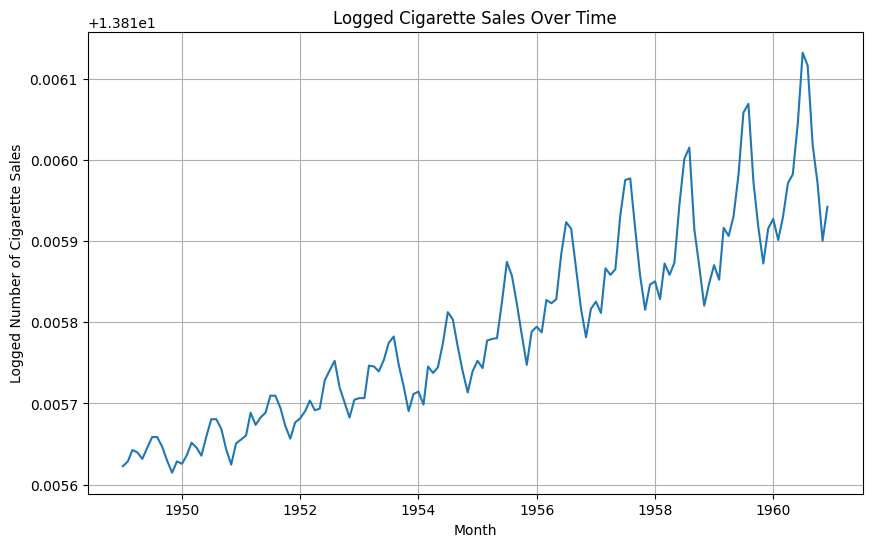

In [19]:
plt.figure(figsize=(10, 6))
plt.plot(y_log)
plt.title('Logged Cigarette Sales Over Time')
plt.xlabel('Month')
plt.ylabel('Logged Number of Cigarette Sales')
plt.grid(True)
plt.show()

We now have a constant variance, but we also need a constant mean.

We can do this by *differencing* our data. We difference a time series dataset when we create a new time series comprising the difference between the values of our existing dataset.

Python is powerful, and we can use the `diff()` function to do this. You'll notice there's one less value than our existing dataset (since we're taking the difference between the existing values).

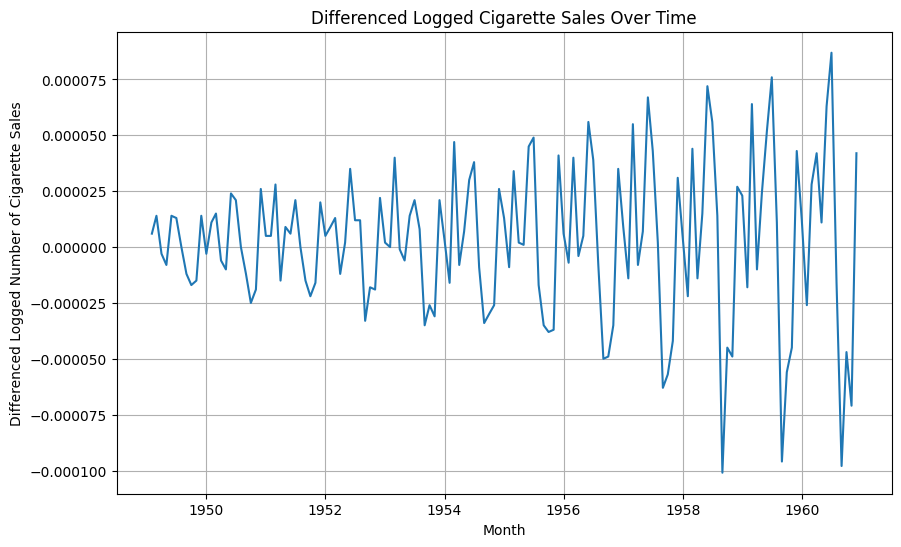

In [20]:
# Difference the logged data
y_log_diff = y_log.diff().dropna()

# Plot the differenced data
plt.figure(figsize=(10, 6))
plt.plot(y_log_diff)
plt.title('Differenced Logged Cigarette Sales Over Time')
plt.xlabel('Month')
plt.ylabel('Differenced Logged Number of Cigarette Sales')
plt.grid(True)
plt.show()


In [21]:
kpss_test(y_log_diff)

Results of KPSS Test:


C:\Users\restr\AppData\Local\Temp\ipykernel_4896\3399100048.py:4: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpsstest = kpss(timeseries, regression='c')


Test Statistic           0.023898
p-value                  0.100000
Lags Used                7.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64

Our p-value is now greater than 0.05, so we can accept the null hypothesis that our data is stationary.

### 3d. The ARIMA model

Recall that ARIMA models are based around the idea that it's possible to predict the next value in a time series by using information about the most recent data points. It also assumes there will be some randomness in our data that can't ever be predicted.

We can find some good parameters for our model using the `sklearn` and `statsmodels` libraries, and in particular `mean_squared_error` and `ARIMA`. 

In [22]:
# Import mean_squared_error and ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA

#### 3di. Make a function to find the MSE of a single ARIMA model
Things get intricate here. Don't worry if you can't do this yourself and need to drop down a Tier. 

We will use the SARIMAX model first:

In [28]:
import itertools
import warnings
from statsmodels.tsa.arima.model import ARIMA

# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 3)

# Generate all different combinations of p, d and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, d and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

warnings.filterwarnings("ignore") # specify to ignore warning messages

best_aic = np.inf
best_pdq = None
best_seasonal_pdq = None
temp_model = None

for param in pdq:
    for param_seasonal in seasonal_pdq:
        
        try:
            temp_model = SARIMAX(y_log,
                               order = param,
                               seasonal_order = param_seasonal,
                               enforce_stationarity=True,
                               enforce_invertibility=True)
            results = temp_model.fit()

            # print("ARIMA{}x{}12 - AIC:{}".format(param, param_seasonal, results.aic))
            if results.aic < best_aic:
                best_aic = results.aic
                best_pdq = param
                best_seasonal_pdq = param_seasonal
        except:
            continue

print("Best SARIMAX{}x{}12 model - AIC:{}".format(best_pdq, best_seasonal_pdq, best_aic))


Best SARIMAX(1, 2, 2)x(1, 0, 1, 12)12 model - AIC:-2739.626606053931


#### and now we will use auto_arima model:

In [51]:
# Use auto_arima to find the best p, d, q parameters
auto_model = auto_arima(y_log, 
                        start_p=0, start_q=0,
                        test='adf',       # use adftest to find optimal 'd'
                        max_p=5, max_q=5, # maximum p and q
                        d=None,           # let model determine 'd'
                        seasonal=True,   # No Seasonality
                        start_P=0, 
                        D=1, 
                        m=12,
                        trace=True,
                        error_action='ignore',  
                        suppress_warnings=True, 
                        stepwise=True)

print(auto_model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=-2559.489, Time=0.14 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-2536.258, Time=0.08 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-2533.703, Time=0.84 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=-2512.025, Time=0.29 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=-2557.480, Time=0.20 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=-2519.431, Time=1.22 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=-2587.581, Time=0.38 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=-2556.298, Time=0.94 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=-2555.978, Time=0.40 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=-2504.214, Time=0.40 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=-2552.856, Time=0.39 sec
 ARIMA(0,1,0)(1,1,0)[12] intercept   : AIC=-2542.671, Time=1.29 sec

Best model:  ARIMA(0,1,0)(1,1,0)[12]          
Total fit time: 6.583 seconds
                                     SARIMAX Results           

The ARIMA model parameters provided by both methods are:

SARIMAX(1, 2, 2)x(1, 0, 1, 12)12 - This means the model is a seasonal ARIMA model with AR order 1, differencing order 2, and MA order 2 for the non-seasonal part, and AR order 1, differencing order 0, and MA order 1 for the seasonal part. The length of the seasonal period is 12.

ARIMA(0,1,0)(1,1,0)[12] - This is also a seasonal ARIMA model with AR order 1, differencing order 0, and MA order 0 for the non-seasonal part, and AR order 1, differencing order 1, and MA order 0 for the seasonal part. The length of the seasonal period is 12.

In [46]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Fit a SARIMAX(1, 2, 2)x(1, 0, 1, 12) model
model_sarimax = SARIMAX(y_log, order=(1, 2, 2), seasonal_order=(1, 0, 1, 12))
model_sarimax_fit = model_sarimax.fit(disp=False)

print(model_sarimax_fit.summary())


                                      SARIMAX Results                                       
Dep. Variable:                            #CigSales   No. Observations:                  144
Model:             SARIMAX(1, 2, 2)x(1, 0, [1], 12)   Log Likelihood                1375.813
Date:                              Tue, 25 Jul 2023   AIC                          -2739.627
Time:                                      12:26:08   BIC                          -2721.892
Sample:                                  01-01-1949   HQIC                         -2732.420
                                       - 12-01-1960                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0367    3.4e-06   1.08e+04      0.000       0.037       0.037
ma.L1         -0.43

In [47]:
# Fit a SARIMAX(0, 1, 0)x(1, 1, 0, 12) model
model_arima = SARIMAX(y_log, order=(0, 1, 0), seasonal_order=(1, 1, 0, 12))
model_arima_fit = model_arima.fit()

print(model_arima_fit.summary())


                                     SARIMAX Results                                      
Dep. Variable:                          #CigSales   No. Observations:                  144
Model:             SARIMAX(1, 0, 0)x(1, 1, 0, 12)   Log Likelihood                1302.949
Date:                            Tue, 25 Jul 2023   AIC                          -2599.898
Time:                                    12:26:14   BIC                          -2591.249
Sample:                                01-01-1949   HQIC                         -2596.383
                                     - 12-01-1960                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9448   3.18e-18   2.97e+17      0.000       0.945       0.945
ar.S.L12       0.8405    7.1e-19   

We can take a look at a summary of the model this library has built around our data.

### 3e. Visualize the results 

Visualize the original dataset plotted against our model. 

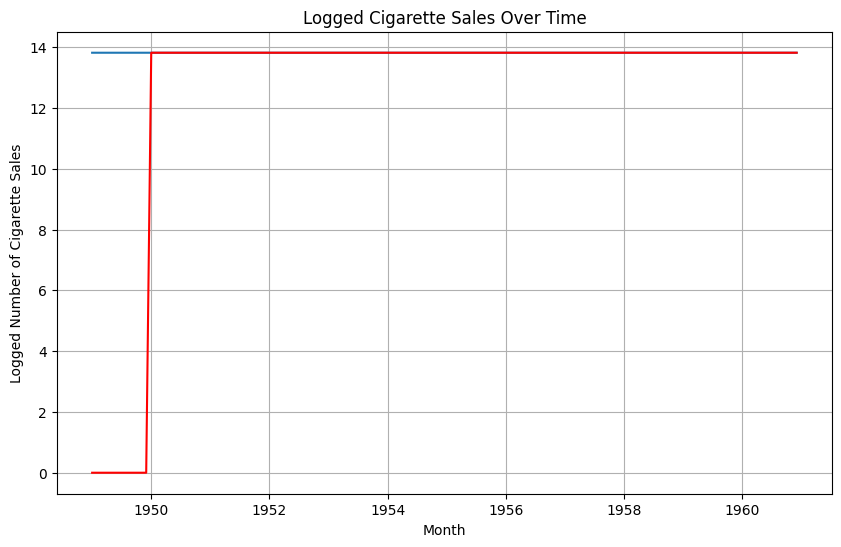

In [57]:
plt.figure(figsize=(10, 6))
plt.plot(y_log)
plt.plot(model_arima_fit.predict(), color = 'red')
plt.title('Logged Cigarette Sales Over Time')
plt.xlabel('Month')
plt.ylabel('Logged Number of Cigarette Sales')
plt.grid(True)
plt.show()

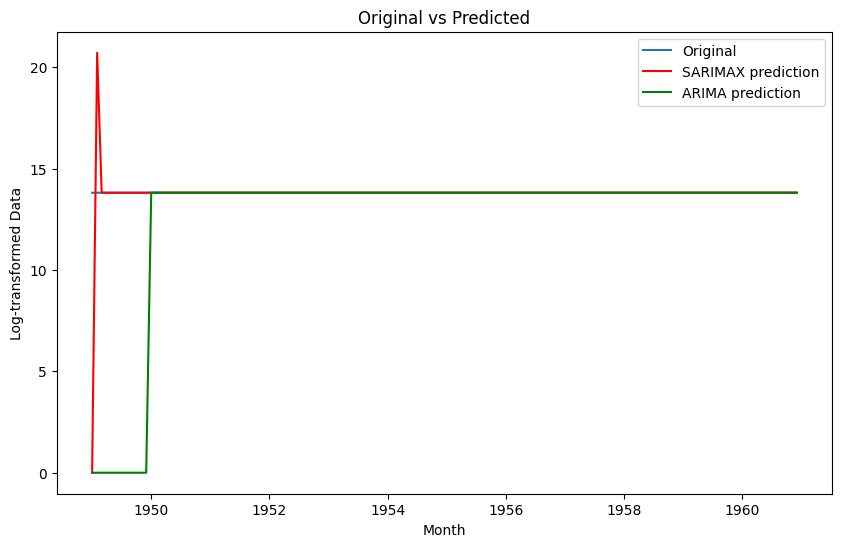

In [54]:
# Generate predictions
sarimax_pred = model_sarimax_fit.predict(start=0, end=len(y_log)-1)
arima_pred = model_arima_fit.predict(start=0, end=len(y_log)-1)

# Plot the original series
plt.figure(figsize=(10,6))
plt.plot(y_log, label='Original')

# Plot the predictions from SARIMAX
plt.plot(sarimax_pred, color='red', label='SARIMAX prediction')

# Plot the predictions from ARIMA
plt.plot(arima_pred, color='green', label='ARIMA prediction')

plt.legend(loc='best')
plt.title('Original vs Predicted')
plt.xlabel('Month')
plt.ylabel('Log-transformed Data')

plt.show()

### 3f. Application: Forecasting

We've done well: our model fits pretty closely to our existing data. Let's now use it to forecast what's likely to occur in future.

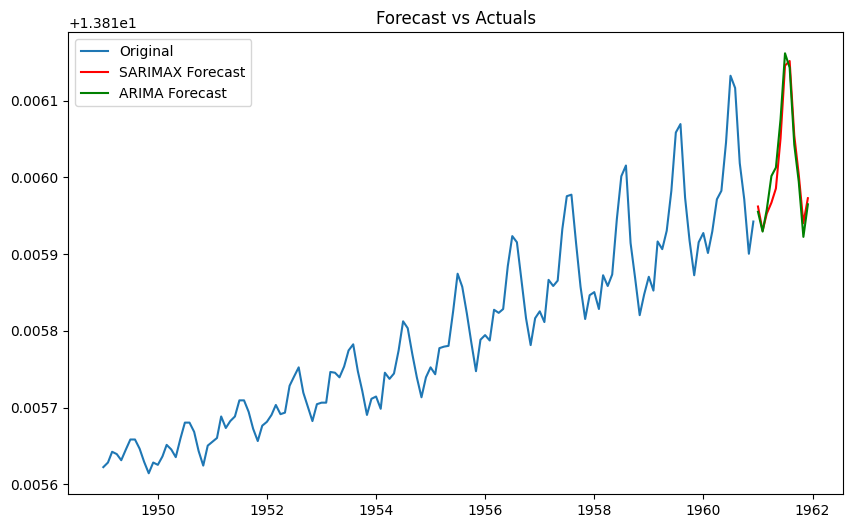

In [55]:
# Number of periods to forecast
forecast_period = 12

# Generate forecast
sarimax_forecast = model_sarimax_fit.get_forecast(steps=forecast_period)
arima_forecast = model_arima_fit.get_forecast(steps=forecast_period)

# Create a range of future dates that is the length of the periods to forecast
future_dates = pd.date_range(y_log.index[-1], periods = forecast_period, freq='MS').shift(1)

# Convert the forecast to a DataFrame
sarimax_df = pd.DataFrame({'Forecast':sarimax_forecast.predicted_mean}, index=future_dates)
arima_df = pd.DataFrame({'Forecast':arima_forecast.predicted_mean}, index=future_dates)

# Plot original data
plt.figure(figsize=(10,6))
plt.plot(y_log, label='Original')

# Plot SARIMAX predictions
plt.plot(sarimax_df, color='red', label='SARIMAX Forecast')
# Plot ARIMA predictions
plt.plot(arima_df, color='green', label='ARIMA Forecast')
plt.legend(loc='best')
plt.title('Forecast vs Actuals')
plt.show()


## 4. Evaluating and Concluding

Our model captures the centre of a line that's increasing at a remarkable rate. Cowboy Cigarettes sell more cigarettes in the summer, perhaps due to the good weather, disposable income and time off that people enjoy, and the least in the winter, when people might be spending less and enjoying less free time outdoors. 

Remarkably, our ARIMA model made predictions using just one variable. We can only speculate, however, on the causes of the behaviour predicted by our model. We should also take heed that spikes in data, due to sudden unusual circumstances like wars, are not handled well by ARIMA; and the outbreak of the Vietnam War in the 1960s would likely cause our model some distress.  

We could suggest to our employers that, if they are interested in discovering the causes of the cigarette sales trajectory, they execute a regression analysis in addition to the time series one. 